In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button
from matplotlib import cm
from matplotlib.patches import Circle
from astropy import units as u
from astropy import constants as const
from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.4, Om0=0.314)
import scipy as sp
import multiprocessing as mp

import time
start_total = time.time()

from plasma_jet_class import sieplasmajet


import warnings
warnings.filterwarnings('ignore')

In [2]:
zl = 0.2; zs = 1.2

Dl = cosmo.angular_diameter_distance(zl)   
Ds = cosmo.angular_diameter_distance(zs)    
Dls = cosmo.angular_diameter_distance_z1z2(zl, zs)

print('Dl: ',Dl); print('Ds: ',Ds); print('Dls: ',Dls)
print('G: ',(const.G).value ,(const.G).unit)
G = const.G
rho_crit = (cosmo.critical_density(zl)).to(u.kg/u.m**3)
print('rho_crit :',rho_crit)
c_light = (const.c).to(u.cm/u.second)
print('c_light :', c_light)

#r0 = 10*u.kpc
r0 = 10.0*u.kpc
#r0 = 0.1*u.kpc
print('r0:', r0)
pi = np.pi

def scale_radius(v,Dl,Ds,Dls):                               #this is e0 in eq 3.42 meneghetti, eq 1 barnacka 2014
    return (4.*pi*v**2/c_light**2*Dl*Dls/Ds).decompose()
def theta_E_SIS():
    'in arcsec'
    pre_theta_E = (scale_radius(v,Dl,Ds,Dls)/Dl).decompose()
    return pre_theta_E*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

v = 180 *u.km/u.s
ss_r = scale_radius(v,Dl,Ds,Dls) 
print('scale radius (m): ',ss_r)
print('scale radius (kpc): ',ss_r.to(u.kpc))
print('theta_E_g: ',theta_E_SIS() ,'arcsec')

theta_E_g = theta_E_SIS()
elipt = eta = 0.3
re = (const.e.esu**2/const.m_e/(c_light**2)).decompose()
print('Classic electron radius: ',re)

Dl:  705.4019455128785 Mpc
Ds:  1760.3796178766652 Mpc
Dls:  1375.6149203241862 Mpc
G:  6.6743e-11 m3 / (kg s2)
rho_crit : 1.0483397591328813e-26 kg / m3
c_light : 29979245800.0 cm / s
r0: 10.0 kpc
scale radius (m):  7.705329461274929e+19 m
scale radius (kpc):  2.49712721364453 kpc
theta_E_g:  0.7301786792241515 arcsec
Classic electron radius:  2.817940324670788e-15 m


In [3]:
theta_0 = (r0/Dl).decompose()*u.rad.to('arcsec', equivalencies=u.dimensionless_angles()) 
print('Angular scale radius (theta_0 = r0/Dl): ',theta_0, 'arcsec')

Angular scale radius (theta_0 = r0/Dl):  2.9240748137875747 arcsec


In [4]:
A = 2.00744300029693
B = 1.5887225542022732
C = 1.4308204791467736

phi = np.linspace(0,2*np.pi, 3000)

In [5]:
eta = 0.3
n0 = 300./(u.cm)**(3)

theta_E_g = theta_E_SIS().value
theta_0_num = theta_0.value

deltab_10 = 0
deltab_20 = 0
delta_rs = .07

In [6]:
x = np.arange(30,200,1)
y = []
for i in x: 
    nu = i * u.MHz
    omega = nu*(1.+zl)*2*np.pi

    psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
                *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

    psi0_plasma_num = psi0_plasma.value
    sie_plasma = sieplasmajet(theta_E_g, eta, phi, psi0_plasma_num, theta_0_num, B, C, delta_rs, deltab_10, deltab_20)
    y_tmp = sie_plasma.d2psi0_dr2
    y.append(y_tmp)

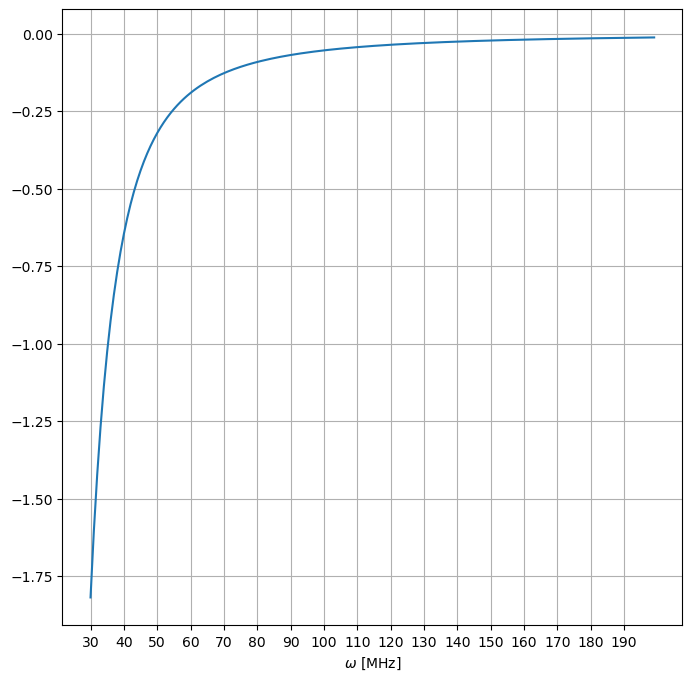

In [7]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()

ax.plot(x,y)
ax.set_xticks(np.arange(30, 200, 10))
ax.set_xlabel(r'$\omega$ [MHz]')
ax.set_ylabel('')

plt.grid()
plt.show()

In [8]:
dbh = 27.4*u.Mpc
separation = 500*u.pc

In [9]:
angularseparation = separation/dbh

In [10]:
(angularseparation.decompose())*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

<Quantity 3.76395632>

In [11]:
Dl

<Quantity 705.40194551 Mpc>

In [12]:
((separation/Dl).decompose())*u.rad.to('arcsec', equivalencies=u.dimensionless_angles())

<Quantity 0.14620374>

In [13]:
(Dl*(5.6e-3)*4.84814e-6).to('pc')

<Quantity 19.15136937 pc>

In [14]:
nu = 300* u.MHz
omega = nu*(1.+zl)*2*np.pi

psi0_plasma = (A*Dls/Ds/Dl*2*pi*c_light**2/omega**2*re*n0*r0 \
            *(u.rad**2).to('arcsec**2', equivalencies=u.dimensionless_angles()) ).decompose()

psi0_plasma_num = psi0_plasma.value

In [15]:
def f(r):
    tmp_f = r - theta_E_g + C/r * (r/B/theta_0_num)**C * psi0_plasma_num*50* np.exp(-(r/B/theta_0_num)**C)
    return tmp_f

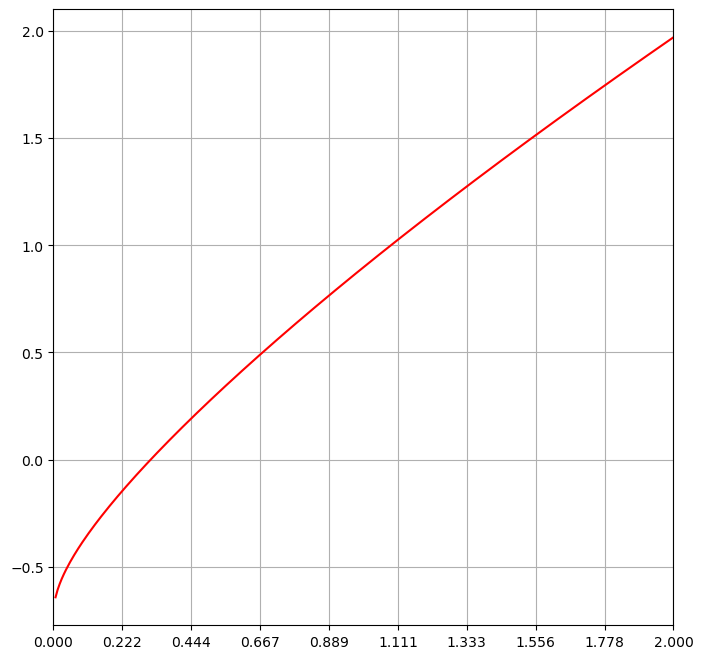

In [16]:

from jupyterthemes import jtplot #These two lines can be skipped if you are not using jupyter themes
jtplot.reset()


figz = plt.figure(figsize=(8,8))
axz = figz.gca()
axz.set_xticks(np.linspace(0, 2, 10))
plt.grid()
axz.set_xlim([0, 2])

r = np.linspace(0,2,300)
axz.plot(r,f(r), color = 'red')
plt.show()

In [20]:
phi = 0
def f(r):
    psi = theta_E_g*r*np.sqrt(1.-eta*np.cos(2.*phi)) + \
              psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C) 
    dpsi = theta_E_g*r*(np.sqrt( 1. - eta*np.cos(2*phi)) - 1)
    psi0 = theta_E_g*r + psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C)
    psi_plasma = psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C)
    ddpsi_dr = theta_E_g*(np.sqrt( 1. - eta*np.cos(2*phi)) - 1)
    ddpsi_dphi = theta_E_g*r*eta*np.sin(2.*phi)/np.sqrt(1.-eta*np.cos(2.*phi))
    d2psi0_dr2 = psi_plasma * ( - C*(C-1)/r**2*(r/B/theta_0_num)**C + (C/r*(r/B/theta_0_num)**C)**2 )
    return d2psi0_dr2

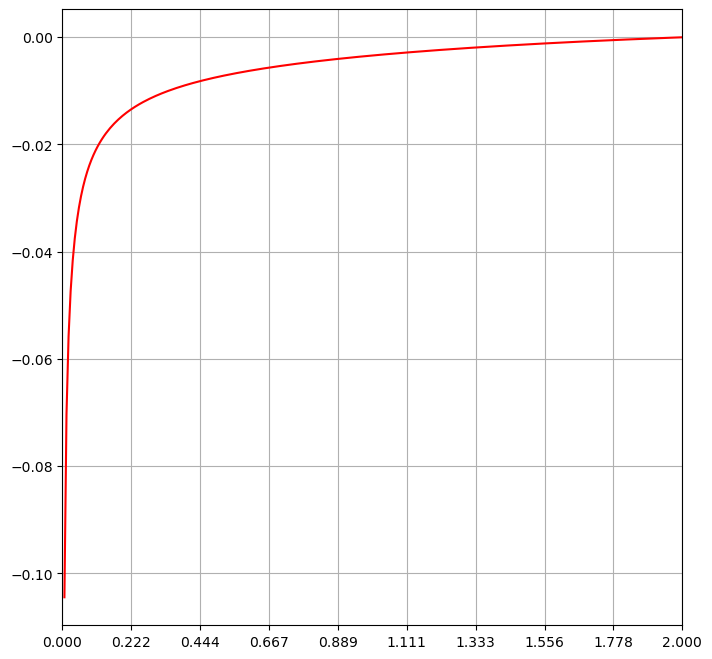

In [37]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.linspace(0, 2, 10))
plt.grid()
ax.set_xlim([0, 2])

r = np.linspace(0,2,300)
ax.plot(r,f(r), color = 'red')
plt.show()

In [40]:
phi = 0
def f(r):
    psi = theta_E_g*r*np.sqrt(1.-eta*np.cos(2.*phi)) + \
              psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C) 
    dpsi = theta_E_g*r*(np.sqrt( 1. - eta*np.cos(2*phi)) - 1)
    psi0 = theta_E_g*r + psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C)
    psi_plasma = psi0_plasma_num*np.exp(-(r/B/theta_0_num)**C)
    ddpsi_dr = theta_E_g*(np.sqrt( 1. - eta*np.cos(2*phi)) - 1)
    ddpsi_dphi = theta_E_g*r*eta*np.sin(2.*phi)/np.sqrt(1.-eta*np.cos(2.*phi))
    d2psi0_dr2 = psi_plasma * C/r**2 *(r/B/theta_0)**C *(1.+C*(  (r/B/theta_0)**C-1)  )
#     d2psi0_dr2 = psi_plasma * C/r**2 *(r/B/theta_0_num)**C *(1.+C*( (r/B/theta_0_num)**(C-1)))
    return d2psi0_dr2

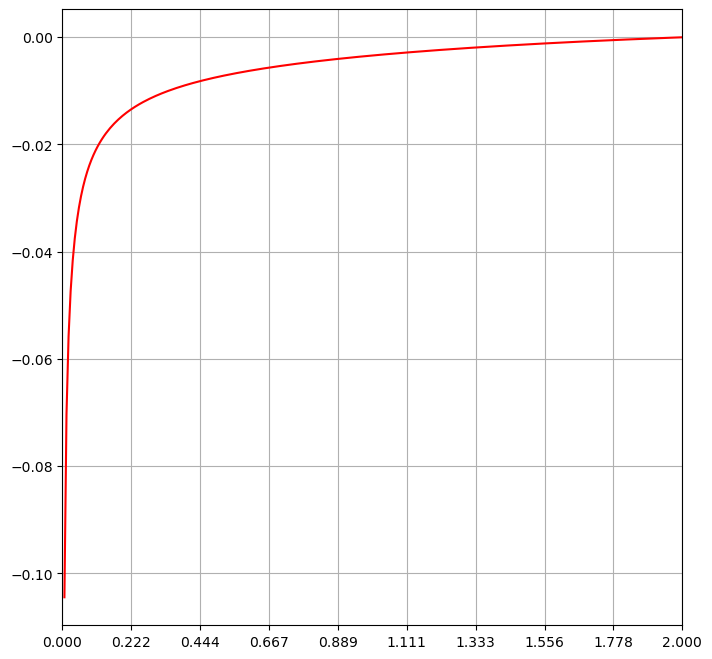

In [41]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xticks(np.linspace(0, 2, 10))
plt.grid()
ax.set_xlim([0, 2])

r = np.linspace(0,2,300)
ax.plot(r,f(r), color = 'red')
plt.show()

In [43]:
atuple = (1,2,3)
btuple = 4,5,6

In [45]:
btuple

(4, 5, 6)